<a href="https://colab.research.google.com/github/OmkarSahasrabudhe/MDS_Learnings/blob/Trimester_2_End-Term/End_Term_Assignment_Team_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# #update local version of the package catalog
!apt-get update
# install Java8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# download spark 3.3.3
!wget -q https://archive.apache.org/dist/spark/spark-3.3.3/spark-3.3.3-bin-hadoop3.tgz
# unzip it
!tar xf spark-3.3.3-bin-hadoop3.tgz
# install findspark
!pip install -q findspark

!pip install mlxtend
!pip install statsmodels

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.3-bin-hadoop3"

import findspark
findspark.init()

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Ign:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [3,186 kB]
Get:14 http://archive.ubuntu.com

In [4]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [5]:
import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.metrics.pairwise import euclidean_distances
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')

In [6]:
spark = SparkSession.builder.appName("Task_2").getOrCreate()

In [7]:
df = spark.read.csv("/content/drive/MyDrive/MDS_Deakin_University/Trimester_2/SIG742-Modern_Data_Science/Task_2/transactionrecord.gz",
                    inferSchema = True, header = True)

In [8]:
df.show()

+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+
|TransactionNo|     Date|ProductNo|         ProductName|Product_category|Price|Quantity|CustomerNo|       Country|
+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+
|       581482|12/9/2019|    22485|Set Of 2 Wooden M...|             0ca|21.47|      12|     17490|United Kingdom|
|       581475|12/9/2019|    22596|Christmas Star Wi...|             0ca|10.65|      36|     13069|United Kingdom|
|       581475|12/9/2019|    23235|Storage Tin Vinta...|             0ca|11.53|      12|     13069|United Kingdom|
|       581475|12/9/2019|    23272|Tree T-Light Hold...|             0ca|10.65|      12|     13069|United Kingdom|
|       581475|12/9/2019|    23239|Set Of 4 Knick Kn...|             0ca|11.94|       6|     13069|United Kingdom|
|       581475|12/9/2019|    21705|Bag 500g Swirly M...|             0ca|10.65| 

In [9]:
# Check for NA values
df.filter(df.CustomerNo.isNull()).show()

+-------------+----+---------+-----------+----------------+-----+--------+----------+-------+
|TransactionNo|Date|ProductNo|ProductName|Product_category|Price|Quantity|CustomerNo|Country|
+-------------+----+---------+-----------+----------------+-----+--------+----------+-------+
+-------------+----+---------+-----------+----------------+-----+--------+----------+-------+



In [10]:
# Check for NA values
df.filter(df.CustomerNo == -1).show()

+-------------+----------+---------+--------------------+----------------+-----+--------+----------+--------------+
|TransactionNo|      Date|ProductNo|         ProductName|Product_category|Price|Quantity|CustomerNo|       Country|
+-------------+----------+---------+--------------------+----------------+-----+--------+----------+--------------+
|      C581406| 12/8/2019|   46000M|Polyester Filler ...|             0ca| 6.19|    -240|        -1|United Kingdom|
|      C581406| 12/8/2019|   46000S|Polyester Filler ...|             0ca| 6.19|    -300|        -1|United Kingdom|
|      C575153| 11/8/2019|    22947|Wooden Advent Cal...|             0ca|44.25|      -1|        -1|United Kingdom|
|      C574288| 11/3/2019|    22178|Victorian Glass H...|             0ca|25.37|      -1|        -1|United Kingdom|
|      C573180|10/28/2019|    23048|Set Of 10 Lantern...|             0ca| 14.5|      -1|        -1|United Kingdom|
|      C569495| 10/4/2019|    21843|Red Retrospot Cak...|             0c

In [11]:
df = df.withColumn("productName_process",F.regexp_replace(F.col("productName"), "[^a-zA-Z]", ""))

# Show the first 5 rows of the processed DataFrame
print(df.show(5))

+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+--------------------+
|TransactionNo|     Date|ProductNo|         ProductName|Product_category|Price|Quantity|CustomerNo|       Country| productName_process|
+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+--------------------+
|       581482|12/9/2019|    22485|Set Of 2 Wooden M...|             0ca|21.47|      12|     17490|United Kingdom|SetOfWoodenMarket...|
|       581475|12/9/2019|    22596|Christmas Star Wi...|             0ca|10.65|      36|     13069|United Kingdom|ChristmasStarWish...|
|       581475|12/9/2019|    23235|Storage Tin Vinta...|             0ca|11.53|      12|     13069|United Kingdom|StorageTinVintage...|
|       581475|12/9/2019|    23272|Tree T-Light Hold...|             0ca|10.65|      12|     13069|United Kingdom|TreeTLightHolderW...|
|       581475|12/9/2019|    23239|Set Of 4 Knic

In [12]:
# 1.2.1 Calculate revenue and save as float
df = df.withColumn("Revenue", (F.col("price") * F.col("Quantity")).cast("float"))

df.show(10)

+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+--------------------+-------+
|TransactionNo|     Date|ProductNo|         ProductName|Product_category|Price|Quantity|CustomerNo|       Country| productName_process|Revenue|
+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+--------------------+-------+
|       581482|12/9/2019|    22485|Set Of 2 Wooden M...|             0ca|21.47|      12|     17490|United Kingdom|SetOfWoodenMarket...| 257.64|
|       581475|12/9/2019|    22596|Christmas Star Wi...|             0ca|10.65|      36|     13069|United Kingdom|ChristmasStarWish...|  383.4|
|       581475|12/9/2019|    23235|Storage Tin Vinta...|             0ca|11.53|      12|     13069|United Kingdom|StorageTinVintage...| 138.36|
|       581475|12/9/2019|    23272|Tree T-Light Hold...|             0ca|10.65|      12|     13069|United Kingdom|TreeTLightHolderW...| 

In [13]:
# 1.2.2 Convert to Pandas DataFrame and create transaction_date column
df = df.toPandas()
df["transaction_date"] = pd.to_datetime(df["Date"])

df.head()

,TransactionNo,Date,ProductNo,ProductName,Product_category,Price,Quantity,CustomerNo,Country,productName_process,Revenue,transaction_date
0,581482,12/9/2019,22485,Set Of 2 Wooden Market Crates,0ca,21.47,12,17490,United Kingdom,SetOfWoodenMarketCrates,257.640015,2019-12-09
1,581475,12/9/2019,22596,Christmas Star Wish List Chalkboard,0ca,10.65,36,13069,United Kingdom,ChristmasStarWishListChalkboard,383.399994,2019-12-09
2,581475,12/9/2019,23235,Storage Tin Vintage Leaf,0ca,11.53,12,13069,United Kingdom,StorageTinVintageLeaf,138.360001,2019-12-09
3,581475,12/9/2019,23272,Tree T-Light Holder Willie Winkie,0ca,10.65,12,13069,United Kingdom,TreeTLightHolderWillieWinkie,127.800003,2019-12-09
4,581475,12/9/2019,23239,Set Of 4 Knick Knack Tins Poppies,0ca,11.94,6,13069,United Kingdom,SetOfKnickKnackTinsPoppies,71.639999,2019-12-09


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536350 entries, 0 to 536349
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   TransactionNo        536350 non-null  object        
 1   Date                 536350 non-null  object        
 2   ProductNo            536350 non-null  object        
 3   ProductName          536350 non-null  object        
 4   Product_category     536350 non-null  object        
 5   Price                536350 non-null  float64       
 6   Quantity             536350 non-null  int32         
 7   CustomerNo           536350 non-null  int32         
 8   Country              536350 non-null  object        
 9   productName_process  536350 non-null  object        
 10  Revenue              536350 non-null  float32       
 11  transaction_date     536350 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float32(1), float64(1), int32(2), object(7)
memory

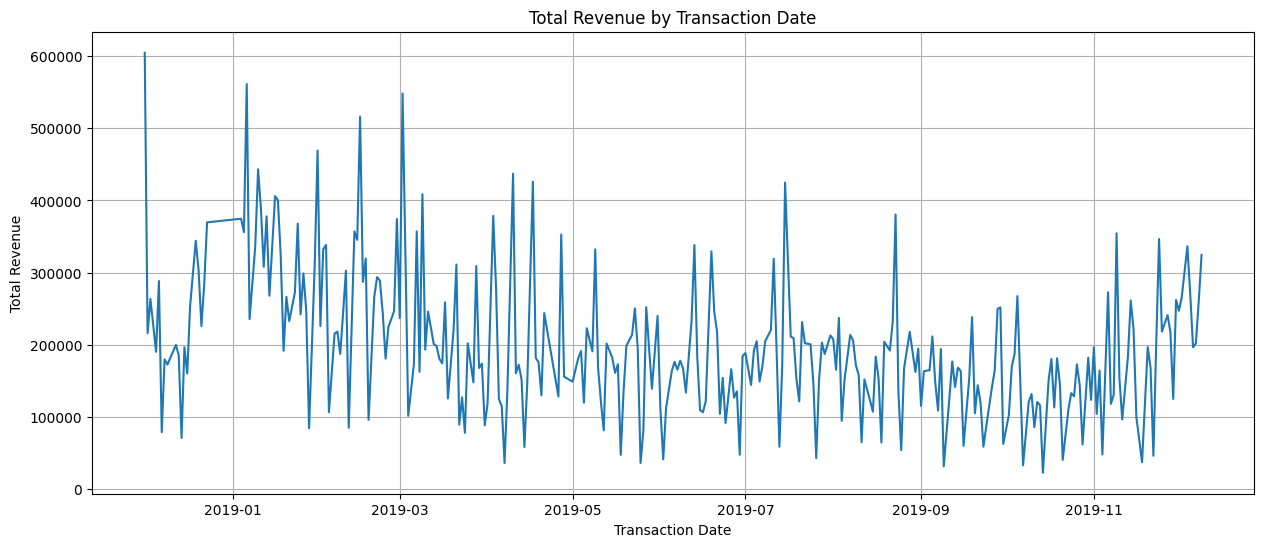

In [15]:
# 1.2.3 Plot the sum of revenue on transaction_date
plt.figure(figsize=(15, 6))
plt.plot(df["transaction_date"].unique(), df["Revenue"].groupby(df["transaction_date"]).sum())
plt.title("Total Revenue by Transaction Date")
plt.xlabel("Transaction Date")
plt.ylabel("Total Revenue")
plt.grid(True)
plt.show()

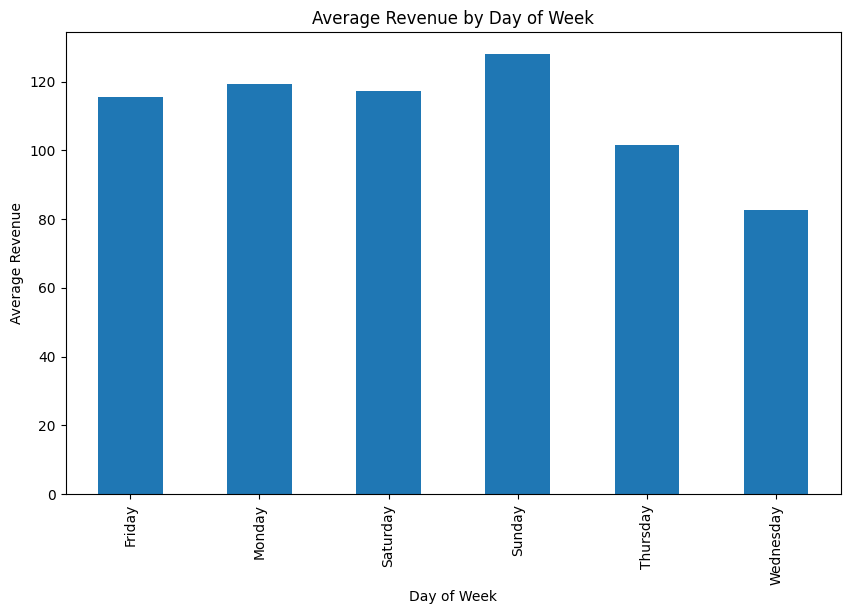

In [16]:
# 1.3.1 Determine the workday with the most sales
df["day_of_week"] = df["transaction_date"].dt.day_name()

# Group by day_of_week and calculate average revenue
avg_revenue_by_day = df.groupby("day_of_week")["Revenue"].mean()

# Plot the results
plt.figure(figsize=(10, 6))
avg_revenue_by_day.plot(kind="bar")
plt.title("Average Revenue by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Average Revenue")
plt.show()

# Find the workday with the most sales
best_day = avg_revenue_by_day.idxmax()

In [17]:
# 1.3.2 Identify top products on the best day
top_revenue_product_best_day = df[df["day_of_week"] == best_day].groupby("productName_process")["Revenue"].sum().idxmax()
top_sales_volume_product_best_day = df[df["day_of_week"] == best_day].groupby("productName_process")["Quantity"].sum().idxmax()

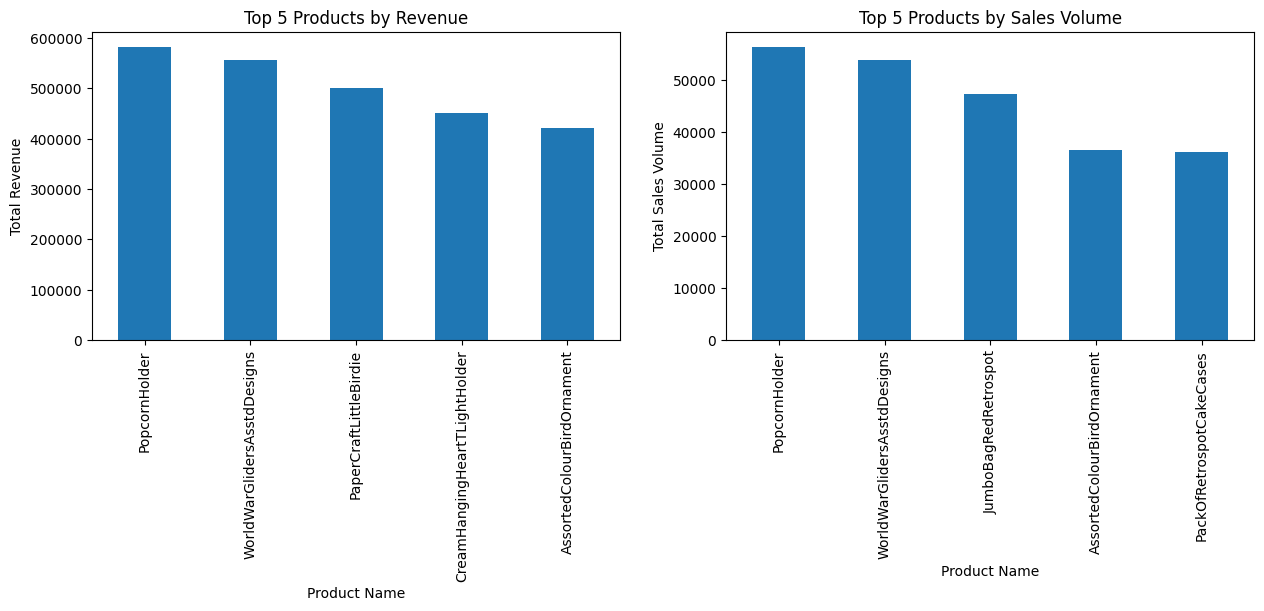

In [18]:
# 1.3.3 Plot top 5 products by revenue and sales volume
top_revenue_products = df.groupby("productName_process")["Revenue"].sum().nlargest(5)
top_sales_volume_products = df.groupby("productName_process")["Quantity"].sum().nlargest(5)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

top_revenue_products.plot(kind="bar", ax=axes[0])
axes[0].set_title("Top 5 Products by Revenue")
axes[0].set_xlabel("Product Name")
axes[0].set_ylabel("Total Revenue")

top_sales_volume_products.plot(kind="bar", ax=axes[1])
axes[1].set_title("Top 5 Products by Sales Volume")
axes[1].set_xlabel("Product Name")
axes[1].set_ylabel("Total Sales Volume")

plt.show()

In [19]:
# Group by country and calculate total revenue
total_revenue_by_country = df.groupby("Country")["Revenue"].sum()

# Find the country with the highest revenue
country_with_highest_revenue = total_revenue_by_country.idxmax()
highest_revenue = total_revenue_by_country.max()

# Find the month with the highest revenue in the top country
df_top_country = df[df["Country"] == country_with_highest_revenue]
df_top_country["Month"] = df_top_country["transaction_date"].dt.month_name()

total_revenue_by_month_top_country = df_top_country.groupby("Month")["Revenue"].sum()
month_with_highest_revenue_top_country = total_revenue_by_month_top_country.idxmax()

# Print the results
print("Country with the highest revenue:", country_with_highest_revenue)
print("Highest revenue:", highest_revenue)
print("Month with the highest revenue in the top country:", month_with_highest_revenue_top_country)
print()

Country with the highest revenue: United Kingdom
Highest revenue: 49994030.0
Month with the highest revenue in the top country: November



In [20]:
# Filter out non-shopping transactions (Quantity <= 0)
df_shopping_transactions = df[df["Quantity"] > 0]

# Group by CustomerNo and count unique transactionNo
customer_shopping_frequency = df_shopping_transactions.groupby("CustomerNo")["TransactionNo"].nunique()

# Find the customer with the highest shopping frequency
most_frequent_shopper = customer_shopping_frequency.idxmax()
highest_frequency = customer_shopping_frequency.max()

# Find the customer's preferred products
preferred_products = df_shopping_transactions[df_shopping_transactions["CustomerNo"] == most_frequent_shopper].groupby("productName_process")["Quantity"].sum().nlargest(5)

# Print the results
print("Customer with the highest shopping frequency:", most_frequent_shopper)
print("Highest shopping frequency:", highest_frequency)
print("Preferred products:")
print(preferred_products)

Customer with the highest shopping frequency: 12748
Highest shopping frequency: 207
Preferred products:
productName_process
VictorianMetalPostcardSpring     595
WorldWarGlidersAsstdDesigns      480
RoseScentCandleJewelledDrawer    408
CartoonPencilSharpeners          405
SmallWhiteRetrospotMugInBox      390
Name: Quantity, dtype: int32


In [21]:
# Filter for positive quantity transactions
df_shopping_transactions = df[df["Quantity"] > 0]

# 1.6.1 Group by transactionNo and aggregate product category and product name
df_grouped = df_shopping_transactions.groupby("TransactionNo").agg(
    Product_category=("Product_category", list),
    productName_process=("productName_process", list)
)

In [22]:
# 1.6.2 Remove adjacent duplicates from product_category list
def remove_adjacent_duplicates(lst):
    result = []
    for item in lst:
        if not result or item != result[-1]:
            result.append(item)
    return result

df_grouped["Product_category"] = df_grouped["Product_category"].apply(remove_adjacent_duplicates)

# Save as df_1 and print the top 10 rows
df_1 = df_grouped
print(df_1.head(10))

              Product_category  \
TransactionNo                    
536365                   [0ca]   
536366                   [0ca]   
536367                   [0ca]   
536368                   [0ca]   
536369                   [0ca]   
536370                   [0ca]   
536371                   [0ca]   
536372                   [0ca]   
536373                   [0ca]   
536374                   [0ca]   

                                             productName_process  
TransactionNo                                                     
536365         [CreamHangingHeartTLightHolder, WhiteMoroccanM...  
536366             [HandWarmerUnionJack, HandWarmerRedRetrospot]  
536367         [AssortedColourBirdOrnament, PoppysPlayhouseBe...  
536368         [JamMakingSetWithJars, RedCoatRackParisFashion...  
536369                                   [BathBuildingBlockWord]  
536370         [AlarmClockBakelikePink, AlarmClockBakelikeRed...  
536371                                 [PaperChainKitSC

In [23]:
# 1.7.1 Create new column prod_len
df_1["prod_len"] = df_1["Product_category"].apply(len)
df_1.head()

,Product_category,productName_process,prod_len
TransactionNo,,,
536365,[0ca],"[CreamHangingHeartTLightHolder, WhiteMoroccanM...",1
536366,[0ca],"[HandWarmerUnionJack, HandWarmerRedRetrospot]",1
536367,[0ca],"[AssortedColourBirdOrnament, PoppysPlayhouseBe...",1
536368,[0ca],"[JamMakingSetWithJars, RedCoatRackParisFashion...",1
536369,[0ca],[BathBuildingBlockWord],1


In [24]:
# 1.7.2 Transform the list into a path-based representation
def data_processing(df, maxlength=3, minlength=1):
    df_filtered = df[(df["prod_len"] <= maxlength) & (df["prod_len"] >= minlength)]

    df_filtered["path"] = df_filtered["Product_category"].apply(
        lambda lst: "start > " + " > ".join(lst) + " > conversion"
    )

    return df_filtered

# Run the function and print the results
df_2 = data_processing(df_1, maxlength=5, minlength=2)
print(df_2.head(10))

                        Product_category  \
TransactionNo                              
536378                   [0ca, 1ca, 0ca]   
536395                   [0ca, 1ca, 0ca]   
536404         [0ca, 1ca, 0ca, 4ca, 0ca]   
536408                   [0ca, 1ca, 0ca]   
536412                   [0ca, 4ca, 0ca]   
536415                   [0ca, 1ca, 0ca]   
536464                   [0ca, 1ca, 0ca]   
536532                   [0ca, 1ca, 0ca]   
536542                        [0ca, 4ca]   
536544         [0ca, 1ca, 0ca, 4ca, 0ca]   

                                             productName_process  prod_len  \
TransactionNo                                                                
536378         [StrawberryCharlotteBag, ChildrensCutleryRetro...         3   
536395         [BlackHeartCardHolder, AssortedColourBirdOrnam...         3   
536404         [HeartIvoryTrellisSmall, ClearDrawerKnobAcryli...         5   
536408         [MagicDrawingSlateDinosaur, MagicDrawingSlateB...         3   
536

In [25]:
# 1.8.1 Count transactions ending with specific patterns
ending_patterns = ["... > 0ca > conversion", "... > 1ca > conversion", "... > 2ca > conversion", "... > 3ca > conversion", "... > 4ca > conversion"]
ending_pattern_counts = [df_2[df_2["path"].str.endswith(pattern)].shape[0] for pattern in ending_patterns]

In [26]:
# 1.8.2 Count occurrences of internal transitions
internal_transitions = ["0ca > 0ca", "0ca > 1ca", "0ca > 2ca", "0ca > 3ca", "0ca > 4ca", "0ca > conversion"]
transition_counts = [df_2["path"].str.count(transition).sum() for transition in internal_transitions]

In [27]:
# 1.8.3 Count occurrences of "...> 0ca > ..."
pattern_0ca = "...> 0ca > ..."
pattern_0ca_count = df_2["path"].str.count(pattern_0ca).sum()

In [28]:
# 1.8.4 Calculate the final value
final_value = sum([transition_count / pattern_0ca_count for transition_count in transition_counts])

In [29]:
# Print the results
print("Ending pattern counts:", ending_pattern_counts)
print("Transition counts:", transition_counts)
print("Pattern 0ca count:", pattern_0ca_count)
print("Final value:", final_value)

Ending pattern counts: [0, 0, 0, 0, 0]
Transition counts: [0, 1222, 1137, 343, 1198, 3056]
Pattern 0ca count: 3995
Final value: 1.7411764705882353


In [30]:
# 1.9.1 Prepare the transaction level product dataframe
df_filtered = df[df["Quantity"] > 0]

# Get the top 100 products by total quantity
top_100_products = df_filtered.groupby("productName_process")["Quantity"].sum().nlargest(100)

# Filter the DataFrame to include only the top 100 products
df_top_100 = df_filtered[df_filtered["productName_process"].isin(top_100_products.index)]

# Pivot the DataFrame to create a transaction-product matrix
basket_df = df_top_100.pivot(columns="productName_process", values="Quantity").fillna(0).reset_index(drop=True)
basket_df[basket_df >= 4] = True
basket_df[basket_df < 4] = False

In [31]:
# basket_df.to_csv("/content/drive/MyDrive/MDS_Deakin_University/Trimester_2/SIG742-Modern_Data_Science/Task_2/basket_df.csv")

In [32]:
# import numpy as np

# dataset = df_top_100.iloc[:,9]
# # df_top_100[["productName_process"]]

# print(len(list(dataset)))

In [33]:
# 1.9.2 Run apriori algorithm with minimum support of 1.5% and minimum basket size of 4
frequent_itemsets = apriori(basket_df, min_support=0.015)

frequent_itemsets

# rules = association_rules(frequent_itemsets, metric="lift")

# # Print the rules
# print(rules)

,support,itemsets


In [34]:
# # 1.9.3 Run apriori algorithm with support >= 1.0% and lift > 10
# frequent_itemsets_2 = apriori(basket_df, min_support=0.01, use_colnames=True)
# rules_2 = association_rules(frequent_itemsets_2, metric="lift", min_threshold=10)

# # Print the rules
# print(rules_2)

In [35]:
# 1.10.1 Build the customer-product dataframe
df_filtered = df[df["Quantity"] > 0]

# Get the top 100 products by total quantity
top_100_products = df_filtered.groupby("productName_process")["Quantity"].sum().nlargest(100)

# Filter the DataFrame to include only the top 100 products
df_top_100 = df_filtered[df_filtered["productName_process"].isin(top_100_products.index)]

# Pivot the DataFrame to create a customer-product matrix
customer_product_matrix = df_top_100.pivot(columns="productName_process", values="Quantity").fillna(0).reset_index(drop=True)

In [ ]:
# 1.10.2 Calculate pairwise Euclidean distance
customer_distances = euclidean_distances(customer_product_matrix)

In [ ]:
# 1.10.3 Find the top 3 most similar customers
def find_similar_customers(customer_id, distance_matrix, top_n=3):
    distances = distance_matrix[customer_id]
    most_similar_indices = distances.argsort()[1:top_n + 1]
    return most_similar_indices

similar_customers_13069 = find_similar_customers(13069, customer_distances)
similar_customers_17490 = find_similar_customers(17490, customer_distances)

In [ ]:
# Print the results
print("Similar customers to 13069:", similar_customers_13069)
print("Similar customers to 17490:", similar_customers_17490)

# Part II

In [ ]:
# # Create the new dataframe with required/interasted columns

# df_time_series = df[["transaction_date", "Revenue"]]

# df_time_series.head()

# # Create a date range covering the entire time period
# start_date = df_time_series["transaction_date"].min()
# end_date = df_time_series["transaction_date"].max()
# date_range = pd.date_range(start_date, end_date)

# # Fill in missing dates with mean revenue
# df_with_missing_dates = pd.DataFrame(index=date_range)

# df_with_missing_dates

# df_with_missing_dates["Revenue"] = df.set_index("transaction_date")["Revenue"]
# df_with_missing_dates["Revenue"].fillna(df["Revenue"].mean(), inplace=True)

# # Decompose the time series
# decomposition = seasonal_decompose(df_with_missing_dates["Revenue"], model="additive")

# # Plot the components
# decomposition.plot()
# plt.show()